# Exercise Sheet 2: Timing, Numpy, Plotting

The previous exercise sheet introduced several methods for classification: decision trees, nearest neighbors, and nearest means. Of those, the one that could learn from the data, and that also offered enough complexity to produce an accurate decision function was k-nearest neighbors. However, nearest neighbors can be slow when implemented in pure Python (i.e. with loops). This is especially the case when the number of data points or input dimensions is large.

In this exercise sheet, we will speed up nearest neighbors by utilizing `numpy` and `scipy` packages. Your task will be to replace list-based operations by vector-based operations between numpy arrays. The speed and correctness of the implementations will then be tested. In particular, performance graphs will be drawn using the library `matplotlib`.

## Python Nearest Neighbor

The most basic element of computation of nearest neighbors is its distance function relating two arbitrary data points `p1` and `p2`. We assume that these points are iterable (i.e. we can use a loop over their dimensions). One way among others to compute the square Euclidean distance between two points is by computing the sum of the component-wise distances

In [16]:
#formerly pydistance
def get_distanceSumOfSquares_py(pattern1,pattern2):
    list_of_pairs_attrPattern1_and_attrPattern2 = zip( pattern1,pattern2 )
    return sum( [ (attrPattern1-attrPattern2)**2 for attrPattern1,attrPattern2 in list_of_pairs_attrPattern1_and_attrPattern2 ] )

where the prefix "`py-`" of the function indicates that the latter makes use of `Python` instead of `numpy`. Once the distance matrix has been implemented, the nearest neighbor for a given unlabeled point `u` that we would like to classify is obtained by iterating over all points in the training set `(X,Y)`, selecting the point with smallest distance to `u`, and returning its corresponding label. Here `X` denotes the list of inputs in the training set and `Y` denotes the list of labels.

In [17]:
#formerly ??
def get_labelNearest_py( attrsUnlabeled , listOfAttrs , listOfLabels , get_distance_between_attrs = get_distanceSumOfSquares_py ):
    
    attrsNearest = None
    labelNearest = None
    distanceNearest = float('inf')
    
    for attrs,label in zip(listOfAttrs,listOfLabels):
        
        distance_between_attrsUnlabeled_and_attrsLabeled = get_distance_between_attrs( attrsUnlabeled , attrs )
        
        if distance_between_attrsUnlabeled_and_attrsLabeled < distanceNearest:
            attrsNearest = attrs
            labelNearest = label
            distanceNearest = distance_between_attrsUnlabeled_and_attrsLabeled
            
    return labelNearest

Note that this function either uses function `pydistance` (given as default if the argument distance is not specified). Or one could specify as argument a more optimized function for distance compuation, for example, one that uses `numpy`. Finally, one might not be interested in classifying a single point, but many of them. The method below receives a collection of such unlabeled test points stored in the variable `U`. The function returns a list of predictions associated to each test point.

In [18]:
# formerly pybatch
def get_listOfNearestLabels( listOfUnlabeledAttrs , listOfAttrs , listOfLabels , get_labelNearest=get_labelNearest_py , get_distance=get_distanceSumOfSquares_py ):
    listOfLabels = [ get_labelNearest( unlabeledAttrs , listOfAttrs , listOfLabels , get_distance_between_attrs=get_distance ) for unlabeledAttrs in listOfUnlabeledAttrs ]
    return listOfLabels

Again, such function uses by default the Python nearest neighbor search (with a specified distance function). However, we can also specified a more optimized nearest neighbor function, for example, based on `numpy`. Finally, one could consider an alternative function to `pybatch` that would use `numpy` from the beginning to the end. The implementation of such more optimized functions, and the testing of their correct behavior and higher performance will be the object of this exercise sheet.

## Testing and correctness

As a starting point, the code below tests the output of the nearest neighbor algorithm for some toy dataset with fixed parameters. In particular, the function `data.toy(M,N,d)` generates a problem with `M` unlabeled test points stored in a matrix `U` of size `(M x d)`, then `N` labeled training points stored in a matrix `X` of size `(N x d)` and the output label is stored in a vector `Y` of size `N` composed of zeros and ones encoding the two possible classes. The variable `d` denotes the number of dimensions of each point. The toy dataset is pseudo-random, that is, for fixed parameters, it produce a random-looking dataset, but every time the method is called with the same parameters, the dataset is the same. The pseudo-randomness property will be useful to verify that each nearest neighbor implementation performs the same overall computation.

In [19]:
import data
# unlabeledAttrs formerly called U
# labeledAttrs   formerly called X
# labels         formerly called Y
unlabeledAttrs , labeledAttrs , labels = data.toy(20,100,50)
print( get_listOfNearestLabels( unlabeledAttrs , labeledAttrs , labels ) )

[1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


In particular, the output of this function will help us to verify that the more optimized `numpy`-based versions of nearest neighbor are still valid.

## Plotting and performance

We now describe how to build a plot that relates a certain parameter of the dataset (e.g. the number of input dimensions `d` to the time required for the computation. We first initialize the basic plotting environment.

In [20]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 90

The command "`%matplotlib inline`" tells IPython notebook that the plots should be rendered inside the notebook. The following code plots the computation time of predicting `100` points from the test set using a training set of size `100`, and where we vary the number of input dimensions.

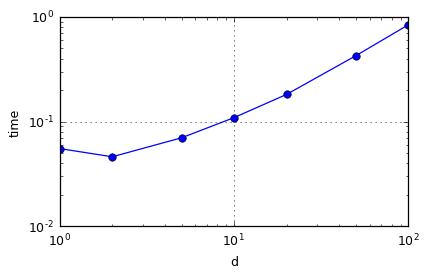

In [21]:
import time

# Values for the number of dimensions d to test
dlist = [1,2,5,10,20,50,100]

# Measure the computation time for each choice of number of dimensions d
tlist = []
for d in dlist:
    U,X,Y = data.toy(100,100,d)
    a = time.clock()
    get_listOfNearestLabels(U,X,Y)
    b = time.clock()
    tlist += [b-a]

# Plot the results in a graph
plt.figure(figsize=(5,3))
plt.plot(dlist,tlist,'-o')
plt.xscale('log');plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)

The time on the vertical axis is in seconds. Note that the exact computation time depends on the speed of your computer. As expected, the computation time increases with the number of input dimensions. Unfortunately, for the small dataset considered here (`100` training and test points of `100` dimensions each), the algorithm already takes more than one second to execute. Thus, it is necessary for practical applications (e.g. the digit recognition task that we will consider at the end of this exercise sheet) to accelerate this nearest neighbor algorithm.

## Accelerating the distance computation (25 P)

In this first exercise, we would like to accelerate the function that compute pairwise distances.

* Create a new function `npdistance(x1,x2)` with the same output as `pydistance(x1,x2)`, but that computes the squared Euclidean distance using `numpy` operations.

* Print its output for the same toy example with parameters `M=20`, `N=100`, `d=50` considered before (i.e. `data.toy(20,100,50)`). Verify that in both cases (i.e. using either `npdistance` or `pydistance` in the function `pybatch`) the output remains the same.

* Create a plot similar to the one above, but where the computation time required by both methods are shown in a superposed manner. Here, we fix `M=100`, `N=100`, and we let `d` vary from `1` to `1000`, taking the list of values `[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]`.

In [ ]:
import numpy as np
import numpy.linalg.norm

def npdistance( attr1, attr2 ):
    return 

* Based on your results, explain what kind of speedup `numpy` provides, and in what regime do you expect the speedup to be the most important.

## Accelerating the nearest neighbor search (25 P)

Motivated by the success of the `numpy` optimized distance computation, we would like further accelerate the code by performing nearest neighbor search directly in `numpy`.

* Create a new function `npnearest(u,X,Y)` as an alternative to the function `pynearest(u,X,Y,distance=npdistance)` that we have used in the previous exercise.

* Print its output for the same toy example as before (i.e. `data.toy(20,100,50)`). Verify that the output remains the same compared to the implementation of the previous exercise.

* Create a plot similar to the one above, where the new method is compared to the previous one. Here, we fix `M=100`, `d=100`, and we let `N` take different values `[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]`.

In [ ]:
### Replace by your own code
import solutions
solutions.exercise2()
###

* Based on your results, explain what kind of speedup this further optimization provides, and in what regime the speedup is the most significant.

## Accelerating the processing of multiple test points (25 P)

Not yet fully happy with the performance of the algorithm, we would like to further optimize it by avoiding performing a loop on the test points, and instead, classify them all at once.

* Create a new function `npbatch(U,X,Y)` as a replacement of the implementation `pybatch(U,X,Y,nearest=npnearest)` that we have built in the previous exercise.

* Print its output for the same dataset `data.toy(20,100,50)` and verify that the output remains the same as for the previous implementation.

* Create a plot comparing the computation time of the new implementation compared to the previous one. Here, we fix `N=100`, `d=100`, and we let `M` vary from `1` to `1000` with values `[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]`.

In [ ]:
### Replace by your own code
import solutions
solutions.exercise3()
###

## Application to real data (25 P)

Having now implemented an efficient K-nearest neighbor classifier, we can test it on real problems with many data points and dimensions. We consider a small handwritten digits recognition dataset, that can be directly obtained from the library `scikit-learn`. This dataset consists of handwritten digits of size `8 x 8` flattened into arrays of size `64`, with class between `0` and `9`. We use a function `data.digits()` to load the data and arrange data points in some predefined order.

In [ ]:
X,Y = data.digits()

Using the function `imshow` of `matplotlib` to visualize the first 100 digits of the dataset.

In [ ]:
### Replace by your own code
import solutions
solutions.exercise4a()
###

* Partition the data into a "training" set and "test" set. The first one contains the 1000 first digits of `X`, and the second one contains the remaining ones.

* Assume that you don't know the labels for the test data and classify the test data using your efficient nearest neighbor implementation.

* Print the predicted labels for the test set.

In [ ]:
### Replace by your own code
import solutions
solutions.exercise4b()
###

Finally, in order to determine the accuracy of the classifier, we would like to compare the predictions with the ground truth (i.e. the true labels from the test data).

* Compute the fraction of the time on the test set where the predictions of the nearest neighbor algorithm and labels disagree. 

In [ ]:
### Replace by your own code
import solutions
solutions.exercise4c()
###